**Mounting to Google Colab**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import All Required Packages**

In [0]:
import csv
import pandas as pd
import numpy as np
# used for encoding
import chardet
# natural language toolkit
import nltk
# wordnet is the database of English language
nltk.download('wordnet')
# stopwords for removing it from review
from nltk.corpus import stopwords
nltk.download('stopwords')
##from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
# ngrams used for bigram input
from nltk.util import ngrams
import string
import math
# importing Linear SVM Classifier 
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
# evaluation measures
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
# for plots and visualizations
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
#universal variable declaration
dataset=[]
trainData=[]
testData=[]
trainData_label=[]
testData_label=[]

# variable declaration for All the feature input
trainDataAll=[]
testDataAll=[]
trainData_labelAll=[]
testData_labelAll=[]

# for removal of punctuation words
table = str.maketrans({key: None for key in string.punctuation})

# Label list
label=[]

tfs = {}      # term frequency
#tfids = {}    #
tfidf = {}    # term frequency Inverse document frequency

tfs_test = {}    # term frequency for test data
#tfids_test = {}
tfidf_test = {}  # term frequency Inverse document frequency for test data

featureDict = {}         # A global dictionary of features
featureDict_test = {}    # A global dictionary of All features

**IMPORT DATASET  **

In [0]:
df = pd.read_csv(r"/content/drive/My Drive/Colab Notebooks/amazon_data.csv", encoding='Latin-1')
df = df.sample(frac=1).reset_index(drop=True)

# Replace the Labels with FAKE and REAL
df = df.replace({'LABEL': {'__label1__':'FAKE' , '__label2__':'REAL'}})

display(df.head())
label=df['LABEL'].tolist()

# Drop the LABEL
#df=df.drop('LABEL',axis=1)
#row,col = df.shape


,DOC_ID,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT
0,1554,FAKE,2,N,Electronics,B000PCEFXQ,Sony MDRRF970RK Wireless Stereo Headphones (Di...,it hissed and popped.,"The headsets never worked well at my computer,..."
1,19463,REAL,5,Y,Office Products,B001GAOTXC,"Pilot Varsity Disposable Fountain Pens, Black ...",Only pen I will use!,I am very particular about the pens that I use...
2,8819,FAKE,5,N,Camera,B008RW6RGE,VANGUARD Abeo Plus 323AB Tripod with BBH-200 P...,Vanguard is a Company with Photographers on Th...,"I've owned, used and abused, several tripods i..."
3,20798,REAL,5,Y,Jewelry,B00PJIO5PO,White Daisy Flower Cluster Bib Pendant Golden ...,LOVE this necklace,LOVE this necklace!!! Very good quality! Nice ...
4,2310,FAKE,3,N,Tools,B000OWAYVY,"IIT 90690 Super Glue, 3 Grams Each, 5-Pack",Ok buttt,This glue set does stick and gets very strong ...


**
VISUALIZATION OF DATASET**

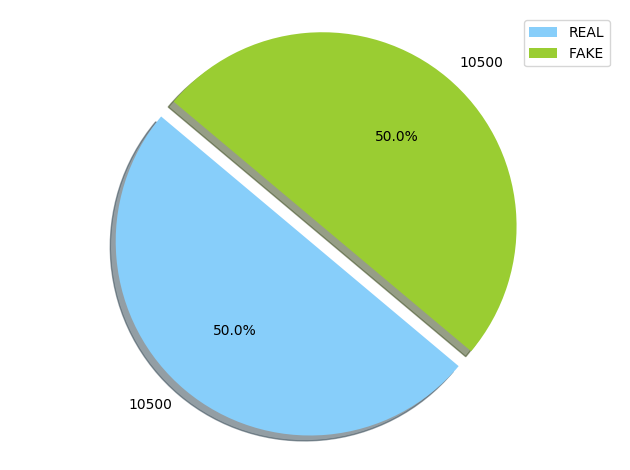

In [0]:
count_real=0
count_fake=0
for x in label:
  if x == 'REAL':
    count_real +=1
  else:
    count_fake +=1

count_rf=[count_real,count_fake] 
# Data to plot
labelss = 'REAL', 'FAKE'
labelss1=count_real,count_fake

colors = ['lightskyblue','yellowgreen']
explode = (0.1, 0)  # explode 1st slice
 

plt.pie(count_rf, explode=explode, labels=labelss1, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.legend(labelss)
plt.tight_layout()
plt.show()


**PARSE DATASET AND EXTRACT ESSENTIAL FEATURES FROM IT**


**Function for Parsing Only Review Text**

In [0]:
def parse(review):
    return (review[7])


**Function for Parsing Rating, Verified Purchase, Product Category, Review Title and Review Text **

In [0]:
def parseAll(review):
  return (review[2],review[3],review[4],review[8],review[1])

**TEXT PREPROCESSING**

In [0]:
def preprocess(text):
    lemmatizer = WordNetLemmatizer()
    filtered_tokens=[]
    lemmatized_tokens = []
    stop_words = set(stopwords.words('english'))
    text = text.translate(table) # translation of text is done here punctuations are replaced with none
    for w in text.split(" "):
        if w not in stop_words:
            lemmatized_tokens.append(lemmatizer.lemmatize(w.lower()))
  
    return lemmatized_tokens 
    

**FUNCTION FOR CONVERTING IN TO VECTOR**

In [0]:
def toFeatureVector(Rating, verified_Purchase, product_Category, tokens):
    localDict = {}
    
#Rating

    #print(Rating)
    featureDict["R"] = 1   
    localDict["R"] = Rating

#Verified_Purchase
  
    featureDict["VP"] = 1
            
    if verified_Purchase == "N":
        localDict["VP"] = 0
    else:
        localDict["VP"] = 1

#Product_Category

    
    if product_Category not in featureDict:
        featureDict[product_Category] = 1
    else:
        featureDict[product_Category] = +1
            
    if product_Category not in localDict:
        localDict[product_Category] = 1
    else:
        localDict[product_Category] = +1
            
            
#Text        

    for token in tokens:
        if token not in featureDict:
            featureDict[token] = 1
        else:
            featureDict[token] = +1
            
        if token not in localDict:
            localDict[token] = 1
        else:
            localDict[token] = +1
    
    return localDict


**DATA SET IN LIST FORM WITH THE DESIRED INPUTS**

In [0]:
dataset1 = list(df.values)
rawData = []
r,c = df.shape
length=len(df)
length
for i in range(length):
  
  ( Rating, verified_Purchase, product_Category, Text, Label) = parseAll(dataset1[i])
  rawData.append(( Rating, verified_Purchase, product_Category, Text, Label))
  
dataset= rawData


**SPLIT Function for All types of Feature Input**

In [0]:
def split(percent):
    dataSamples = len(dataset)
    halfOfData = int(len(dataset)/2)
    trainingSamples = int((percent*dataSamples)/2)
    
  
    for (Rating, verified_Purchase, product_Category, Text, Label) in dataset[:trainingSamples] + dataset[halfOfData:halfOfData+trainingSamples]:
        trainData.append((toFeatureVector(Rating, verified_Purchase, product_Category, preprocess(Text)),Label))
    for ( Rating, verified_Purchase, product_Category, Text, Label) in dataset[trainingSamples:halfOfData] + dataset[halfOfData+trainingSamples:]:
        testData.append((toFeatureVector(Rating, verified_Purchase, product_Category, preprocess(Text)),Label))
   

**TRAINING CLASSIFIER FUNCTION USING LINEAR SVM**

In [0]:
def trainClassifier(trainclassifier):
    print("Training Classifier")
    pipeline =  Pipeline([('svc', LinearSVC())])
    return SklearnClassifier(pipeline).train(trainclassifier)

**TRAINING CLASSIFIER FUNCTION USING LINEAR SVM**

In [0]:
def crossValidate(dataset_cv, folds):
    cv_results = []
    foldSize = int(len(dataset_cv)/folds)
    for i in range(0,len(dataset_cv),foldSize):
        classifier = trainClassifier(dataset_cv[:i]+dataset_cv[foldSize+i:])
        y_pred = predictLabels(dataset_cv[i:i+foldSize],classifier)
        a = accuracy_score(list(map(lambda d : d[1], dataset_cv[i:i+foldSize])), y_pred)
        (p,r,f,_) = precision_recall_fscore_support(list(map(lambda d : d[1], dataset_cv[i:i+foldSize])), y_pred, average ='macro')
        #print(a,p,r,f)
        cv_results.append((a,p,r,f))
    cv_results = (np.mean(np.array(cv_results),axis=0))
    return cv_results

**TRAINING CLASSIFIER FUNCTION USING LINEAR SVM**

In [0]:
def predictLabels(reviewSamples, classifier1):
    return classifier1.classify_many(map(lambda t: t[0], reviewSamples))



**SPLIT FUNCTION CALLED**

In [0]:
split(0.80)

**CROSS-VALIDATE CALLED **

In [0]:
# Fold = 10

print("Now %d rawData, %d trainData, %d testData" % (len(dataset), len(trainData), len(testData)),
               "Training Samples: ", len(dataset), "Features: ", len(featureDict), sep='\n')
CV_RES = crossValidate(trainData, 10)
print("Mean of cross-validations (Accuracy, Precision, Recall, Fscore): ", CV_RES)

Now 21000 rawData, 16800 trainData, 4200 testData
Training Samples: 
21000
Features: 
42384
Training Classifier
Training Classifier
Training Classifier
Training Classifier
Training Classifier
Training Classifier
Training Classifier
Training Classifier
Training Classifier
Training Classifier
Mean of cross-validations (Accuracy, Precision, Recall, Fscore):  [0.75767857 0.75744025 0.75744354 0.75738744]


**VISUALIZATION OF CROSS-VALIDATION WITH 10 FOLDS**

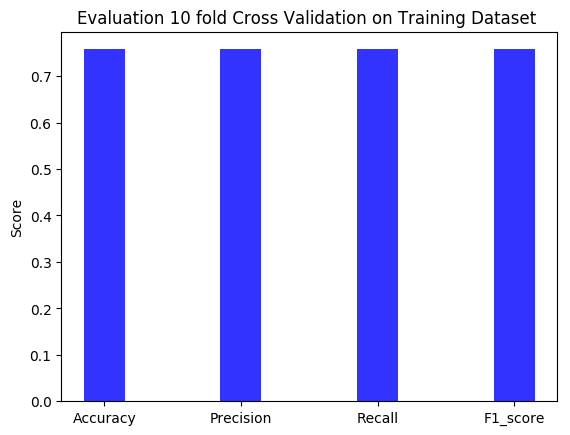

In [0]:
objects = ('Accuracy', 'Precision', 'Recall', 'F1_score')

performance = CV_RES
bar_width=0.3
rects1 = plt.bar(objects, performance,bar_width ,alpha=0.8,color='b',)
 
plt.xticks(objects, objects)
plt.ylabel('Score')
plt.title('Evaluation 10 fold Cross Validation on Training Dataset ')


plt.show()

**TESTING ACCURACY USING TEST SET**

In [0]:
## Test Accuracy
classifier = trainClassifier(trainData)
predictions = predictLabels(testData, classifier)
true_labels = list(map(lambda d: d[1], testData))
a = accuracy_score(true_labels, predictions)
p, r, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='macro')
print("accuracy: ", a)
print("Precision: ", p)
print("Recall: ", r)
print("f1-score: ", f1)

TEST_RES = [a,p,r,f1]

Training Classifier
accuracy:  0.76
Precision:  0.7601476517102264
Recall:  0.759994276642693
f1-score:  0.7599632052441598


**VISUALIZATION OF PREDICTION RESULT ON TEST DATA SET**

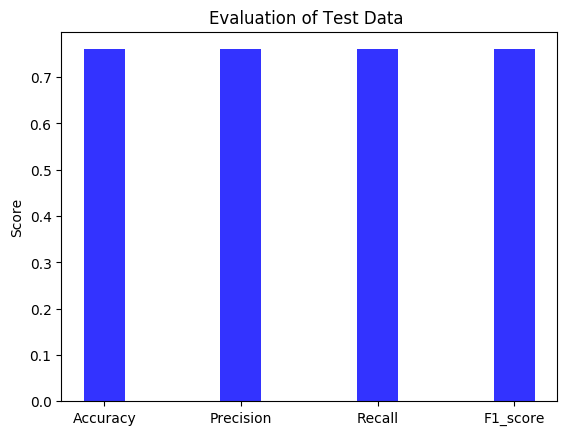

In [0]:
objects = ('Accuracy', 'Precision', 'Recall', 'F1_score')

performance = TEST_RES
bar_width=0.3
rects1 = plt.bar(objects, performance,bar_width ,alpha=0.8,color='b',)
 

plt.xticks(objects, objects)
plt.ylabel('Score')
plt.title('Evaluation of Test Data ')


plt.show()

**VISUALIZATION OF WORD CLOUD**

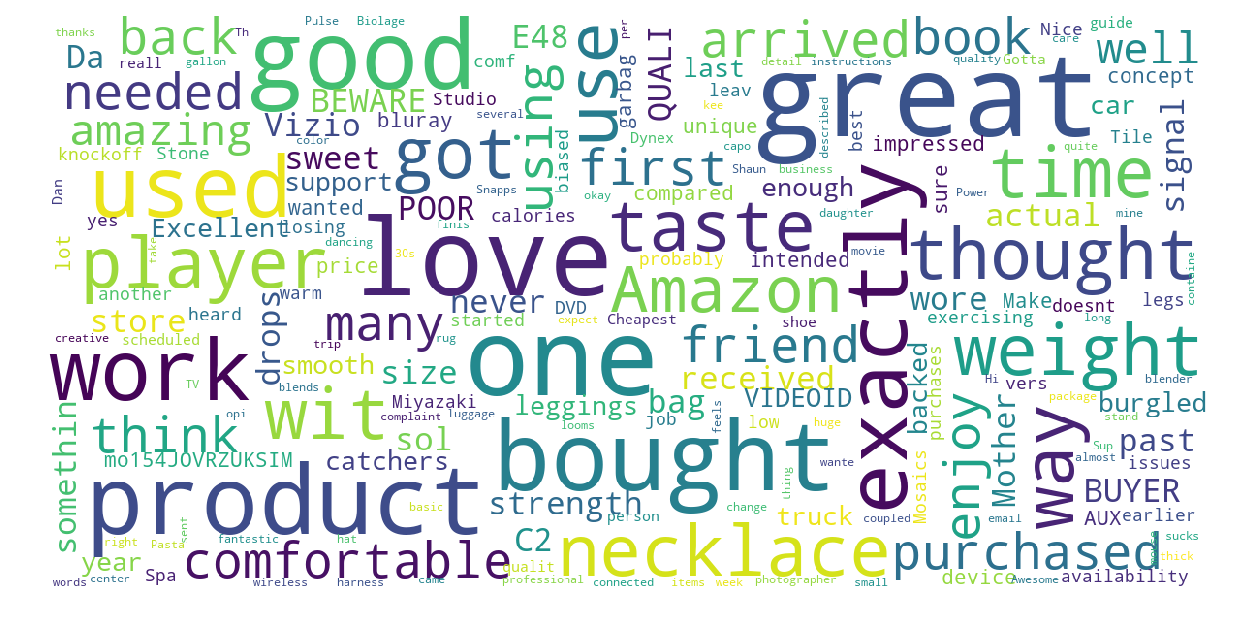

In [0]:
# word cloud Creation
from wordcloud import WordCloud,STOPWORDS
stopwords = set(STOPWORDS)
def show_wordcloud(data1, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data1))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(df['REVIEW_TEXT'])